# Boilerplate

Packae installation, loading, and dataloaders. There's also a simple model defined. You can change it your favourite architecture if you want.

In [88]:
# !pip install tensorboardX

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Simple NN. You can change this if you want.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,10)

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return x

class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), Net())

model = model.to(device)
model.train()

Sequential(
  (0): Normalize()
  (1): Net(
    (fc): Linear(in_features=784, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=10, bias=True)
  )
)

# Implement the Attacks

Functions are given a simple useful signature that you can start with. Feel free to extend the signature as you see fit.

You may find it useful to create a 'batched' version of PGD that you can use to create the adversarial attack.

In [98]:
# The last argument 'targeted' can be used to toggle between a targeted and untargeted attack.
def fgsm(model, x, target, eps, targeted=True):
    model.eval()
    x.requires_grad_()
    ce_loss = torch.nn.CrossEntropyLoss()
    output = model(x)
    if targeted:
        target = 9 - target
    loss = ce_loss(output, target)
    loss.backward()
    
    if targeted:
        adv_x = x - eps * x.grad.data.sign()
    else:
        adv_x = x + eps * x.grad.data.sign()
        
    # clamp it to [0, 1]
    adv_x = torch.clamp(adv_x, 0.0, 1.0)
    
    return adv_x

def pgd_untargeted(model, x, labels, k, eps, eps_step):
    model.eval()
    ce_loss = torch.nn.CrossEntropyLoss()
    adv_x = x.clone().detach()
    adv_x.requires_grad_(True) 
    for _ in range(k):
        adv_x.requires_grad_(True)
        model.zero_grad()
        output = model(adv_x)
        loss = ce_loss(output, labels)
        loss.backward()
        delta = eps_step * adv_x.grad.data.sign()
        adv_x = adv_x + delta
        adv_x = torch.min(torch.max(adv_x, x - eps), x + eps)
        adv_x = torch.clamp(adv_x, 0.0, 1.0)
        adv_x = adv_x.clone().detach()
   
    return adv_x

# Implement Adversarial Training

In [90]:
def train_model(model, num_epochs, enable_defense=True, attack='fgsm', eps=0.1):
    learning_rate = 0.0001

    opt = optim.Adam(params=model.parameters(), lr=learning_rate)

    ce_loss = torch.nn.CrossEntropyLoss()

    tot_steps = 0

    for epoch in range(1,num_epochs+1):
        t1 = time.time()
        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):

            if enable_defense:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                tot_steps += 1
                opt.zero_grad()
                if attack == 'fgsm':
                    x_adv = fgsm(model, x_batch, y_batch, eps, False)
                elif attack == 'pgd':
                    x_adv = pgd_untargeted(model, x_batch, y_batch, 10, eps, eps/4.)
                else:
                    pass
                out = model(x_adv)
                batch_loss = ce_loss(out, y_batch)
                batch_loss.backward()
                opt.step()
            else:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                tot_steps += 1
                opt.zero_grad()
                out = model(x_batch)
                batch_loss = ce_loss(out, y_batch)
                batch_loss.backward()
                opt.step()

        tot_test, tot_acc = 0.0, 0.0
        for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            out = model(x_batch)
            pred = torch.max(out, dim=1)[1]
            acc = pred.eq(y_batch).sum().item()
            tot_acc += acc
            tot_test += x_batch.size()[0]
        t2 = time.time()

        print('Epoch %d: Accuracy %.5lf [%.2lf seconds]' % (epoch, tot_acc/tot_test, t2-t1))
        
        if enable_defense:
            test_model_on_attacks(model, 'pgd')

In [96]:
def test_model_on_attacks(model, attack='fgsm', eps=0.1):
    model.eval()
    tot_test, tot_acc = 0.0, 0.0
    for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        if attack == 'fgsm':
            x_adv = fgsm(model, x_batch, y_batch, eps, True)
        elif attack == 'pgd':
            x_adv = pgd_untargeted(model, x_batch, y_batch, 10, eps, eps/4.)
        else:
            pass
        out = model(x_adv)
        pred = torch.max(out, dim=1)[1]
        acc = pred.eq(y_batch).sum().item()
        tot_acc += acc
        tot_test += x_batch.size()[0]
        # if batch_idx == 22:
        #     plt.imshow(x_batch[2].squeeze(0).detach().numpy())
        #     plt.savefig(f'{attack}_original.png')
        #     plt.imshow(x_adv[2].squeeze(0).detach().numpy())
        #     plt.savefig(f'{attack}_{eps}_adv.png')
            
    print('Robust accuracy %.5lf' % (tot_acc/tot_test), f'on {attack} attack with eps = {eps}')

# Study Accuracy, Quality, etc.

Compare the various results and report your observations on the submission.

In [35]:
## train the original model
train_model(model, 20, False)
torch.save(model.state_dict(), 'weights.pt')

Epoch 1: Accuracy 0.91920 [7.65 seconds]
Epoch 2: Accuracy 0.93710 [6.85 seconds]
Epoch 3: Accuracy 0.94660 [7.94 seconds]
Epoch 4: Accuracy 0.95380 [7.22 seconds]
Epoch 5: Accuracy 0.95910 [7.45 seconds]
Epoch 6: Accuracy 0.96460 [8.08 seconds]
Epoch 7: Accuracy 0.96750 [7.34 seconds]
Epoch 8: Accuracy 0.96980 [7.45 seconds]
Epoch 9: Accuracy 0.97110 [7.70 seconds]
Epoch 10: Accuracy 0.97370 [7.26 seconds]
Epoch 11: Accuracy 0.97430 [7.21 seconds]
Epoch 12: Accuracy 0.97520 [7.79 seconds]
Epoch 13: Accuracy 0.97700 [7.15 seconds]
Epoch 14: Accuracy 0.97740 [7.25 seconds]
Epoch 15: Accuracy 0.97700 [7.11 seconds]
Epoch 16: Accuracy 0.97810 [6.96 seconds]
Epoch 17: Accuracy 0.97840 [7.17 seconds]
Epoch 18: Accuracy 0.97880 [6.73 seconds]
Epoch 19: Accuracy 0.97940 [6.69 seconds]
Epoch 20: Accuracy 0.97850 [8.86 seconds]


Robust accuracy 0.70700 on fgsm attack with radius = 0.05
Robust accuracy 0.15580 on fgsm attack with radius = 0.1
Robust accuracy 0.02030 on fgsm attack with radius = 0.15
Robust accuracy 0.00370 on fgsm attack with radius = 0.2


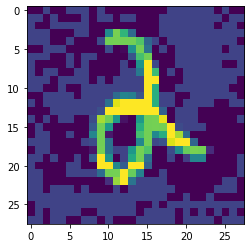

In [72]:
## FGSM attack - untargeted
model = nn.Sequential(Normalize(), Net())
model.load_state_dict(torch.load('weights.pt'))

for eps in [0.05, 0.1, 0.15, 0.2]:
    test_model_on_attacks(model, attack='fgsm', eps=eps)

In [99]:
## FGSM attack - targeted
model = nn.Sequential(Normalize(), Net())
model.load_state_dict(torch.load('weights.pt'))

for eps in [0.05, 0.1, 0.15, 0.2]:
    test_model_on_attacks(model, attack='fgsm', eps=eps)

Robust accuracy 0.86040 on fgsm attack with eps = 0.05
Robust accuracy 0.42240 on fgsm attack with eps = 0.1
Robust accuracy 0.10720 on fgsm attack with eps = 0.15
Robust accuracy 0.01320 on fgsm attack with eps = 0.2


Robust accuracy 0.66720 on pgd attack with radius = 0.05
Robust accuracy 0.10550 on pgd attack with radius = 0.1
Robust accuracy 0.00650 on pgd attack with radius = 0.15
Robust accuracy 0.00010 on pgd attack with radius = 0.2


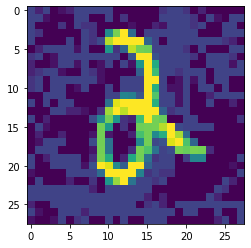

In [85]:
## PGD attack
model = nn.Sequential(Normalize(), Net())
model.load_state_dict(torch.load('weights.pt'))

for eps in [0.05, 0.1, 0.15, 0.2]:
    test_model_on_attacks(model, attack='pgd', eps=eps)

In [87]:
## PGD based adversarial training
model = nn.Sequential(Normalize(), Net())
eps = 0.1
train_model(model, 20, True, 'pgd', eps)
torch.save(model.state_dict(), f'weights_AT_{eps}.pt')

Epoch 1: Accuracy 0.89960 [21.60 seconds]
Epoch 2: Accuracy 0.92580 [22.35 seconds]
Epoch 3: Accuracy 0.93840 [21.98 seconds]
Epoch 4: Accuracy 0.94690 [27.85 seconds]
Epoch 5: Accuracy 0.95380 [23.99 seconds]
Epoch 6: Accuracy 0.95830 [23.35 seconds]
Epoch 7: Accuracy 0.96090 [22.51 seconds]
Epoch 8: Accuracy 0.96430 [22.07 seconds]
Epoch 9: Accuracy 0.96610 [22.36 seconds]
Epoch 10: Accuracy 0.96790 [23.55 seconds]
Epoch 11: Accuracy 0.96890 [20.79 seconds]
Epoch 12: Accuracy 0.97020 [20.93 seconds]
Epoch 13: Accuracy 0.97150 [24.69 seconds]
Epoch 14: Accuracy 0.97280 [23.57 seconds]
Epoch 15: Accuracy 0.97260 [24.31 seconds]
Epoch 16: Accuracy 0.97450 [23.54 seconds]
Epoch 17: Accuracy 0.97530 [25.17 seconds]
Epoch 18: Accuracy 0.97560 [24.21 seconds]
Epoch 19: Accuracy 0.97630 [22.33 seconds]
Epoch 20: Accuracy 0.97640 [22.45 seconds]


In [95]:
## test AT based training model
model = nn.Sequential(Normalize(), Net())
model.load_state_dict(torch.load('weights_AT_0.1.pt'))

for eps in [0.05, 0.1, 0.15, 0.2]:
    test_model_on_attacks(model, attack='pgd', eps=eps)
    
for eps in [0.05, 0.1, 0.15, 0.2]:
    test_model_on_attacks(model, attack='fgsm', eps=eps)

Robust accuracy 0.94440 on pgd attack with eps = 0.05
Robust accuracy 0.87630 on pgd attack with eps = 0.1
Robust accuracy 0.72020 on pgd attack with eps = 0.15
Robust accuracy 0.40970 on pgd attack with eps = 0.2
Robust accuracy 0.94580 on fgsm attack with eps = 0.05
Robust accuracy 0.88760 on fgsm attack with eps = 0.1
Robust accuracy 0.77610 on fgsm attack with eps = 0.15
Robust accuracy 0.57550 on fgsm attack with eps = 0.2


In [100]:
## FGSM attack - targeted on AT
model = nn.Sequential(Normalize(), Net())
model.load_state_dict(torch.load('weights_AT_0.1.pt'))

for eps in [0.05, 0.1, 0.15, 0.2]:
    test_model_on_attacks(model, attack='fgsm', eps=eps)

Robust accuracy 0.97110 on fgsm attack with eps = 0.05
Robust accuracy 0.95140 on fgsm attack with eps = 0.1
Robust accuracy 0.89750 on fgsm attack with eps = 0.15
Robust accuracy 0.77920 on fgsm attack with eps = 0.2
